# Optimization of Scientific Code with Cython: Ising Model

*This notebook originally appeared as a [post](http://jakevdp.github.io/blog/2017/12/11/live-coding-cython-ising-model/) on the blog [Pythonic Perambulations](http://jakevdp.github.io).*

<!-- PELICAN_BEGIN_SUMMARY -->

Python is quick and easy to code, but can be slow when doing intensive numerical operations. Translating code to Cython can be helpful, but in most cases requires a bit of trial and error to achieve the optimal result. [Cython's tutorials](http://cython.readthedocs.io/en/latest/src/tutorial/) contain a lot of information, but for iterative workflows like optimization with Cython, it's often useful to see it done "live".

For that reason, I decided to record some screencasts showing this iterative optimization process, using an  [Ising Model](https://en.wikipedia.org/wiki/Ising_model), as an example application.

<!-- PELICAN_END_SUMMARY -->

## When to use Cython

Before I get to the videos, I wanted to say a few words about *when* and *why* you might choose Cython.

With scientific Python code, before turning to Cython I'd suggest going as far as you can with *vectorization*.
Vectorization involves the judicious use of built-in routines in NumPy, SciPy, Pandas, and other libraries to reduce the number of explicit for-loops in your code. It can work quite well in many situations, and doesn't require any sort of special compilation step in running your code. See my PyCon 2015 talk, [Losing Your Loops](https://www.youtube.com/watch?v=EEUXKG97YRw) for an intro to this approach.

When a problem cannot be easily solved using standard vectorization approaches, Cython is a good choice.
Cython provides a bridge between Python and C code, and is quite mature and reliable: it forms the basis of much of the PyData/Scientific Python ecosystem (for example, Cython is used heavily in NumPy, SciPy, Pandas, Scikit-Learn, and many other packages).

Other approaches to optimizing Python code are available, but I tend not to use them as often as Cython:

The [PyPy](https://pypy.org/) project is an alternative implementation of Python that avoids the slow loops of the default CPython implementation. Although it is quite promising, it currently does not support many of the core scientific packages, so is not the best choice for scientific code (though that has been changing).

[Numba](http://numba.pydata.org/) is a Python-to-LLVM converter which can often give you 100x speedups in Python by adding a simple compilation decorator to Python functions. For an example of Numba being used on code like that in this notebook, see [Matthew Rocklin's post](http://matthewrocklin.com/blog/work/2015/02/28/Ising). Though it is convenient, Numba doesn't support all Python constructs yet, and can be difficult to optimize when the most straightforward approach fails.

## The Code

Below you can find the code that I wrote in those two videos:

### 1. Simple Python Ising Model

#### Implementing the Ising Model

In [9]:
import numpy as np

# ---------------------------------------------------------------
# helpers
# ---------------------------------------------------------------
def random_spin_field(N, M):
    """Return an N × M array of ±1 spins."""
    return np.random.choice([-1, 1], size=(N, M))

def _single_spin_update(field, n, m, beta, J, h_mask):
    """
    Metropolis attempt on a single spin at (n,m).

    ΔE = 2 s_i ( J ∑_nn s_j + h_mask )
    """
    N, M = field.shape
    s = field[n, m]

    # 4-nearest-neighbour contribution
    nb = (
        field[(n-1) % N, m] + field[(n+1) % N, m] +
        field[n, (m-1) % M] + field[n, (m+1) % M]
    )

    dE = 2.0 * s * (J * nb + h_mask)

    if dE <= 0 or np.random.rand() < np.exp(-beta * dE):
        field[n, m] = -s

# ---------------------------------------------------------------
# two-component sweep with MEAN-FIELD TERM
# ---------------------------------------------------------------
def two_comp_step_mean_field(field_x, field_y, beta, Jx=1.0, Jy=1.0, K=0.0, h_x=0.0, h_y=0.0):
    """
    Modified to include mean-field term: -K〈P〉∑ₖ Pₖ
    
    Parameters
    ----------
    field_x, field_y : 2-D numpy arrays of ±1
    beta : 1 / T_sim
    Jx, Jy: nearest-neighbour couplings
    K    : mean-field coupling strength
    h_x, h_y : external-field strengths
    """
    N, M = field_x.shape
    assert field_y.shape == (N, M)
    
    # Calculate current polarization averages
    P_x = np.mean(field_x)  # 〈P_x〉
    P_y = np.mean(field_y)  # 〈P_y〉
    
    # Calculate mean-field contributions
    mean_field_x = K * P_y  # -K〈P_y〉∑ₖ P_x,k
    mean_field_y = K * P_x  # -K〈P_x〉∑ₖ P_y,k
    
    # Total effective fields
    eff_h_x = h_x + mean_field_x
    eff_h_y = h_y + mean_field_y

    # ----- red-black sweep -----
    for n_off in (0, 1):
        for m_off in (0, 1):
            for n in range(n_off, N, 2):
                for m in range(m_off, M, 2):
                    # Update x-component
                    _single_spin_update(field_x, n, m, beta, Jx, eff_h_x)
                    
                    # Update y-component
                    _single_spin_update(field_y, n, m, beta, Jy, eff_h_y)

    return field_x, field_y

# Transition Temperature

In [17]:
import numpy as np
from tqdm import tqdm

# ---------------------------------------------------------------
# Simulation parameters
# ---------------------------------------------------------------
L = 16                  # System size
thermalisation = 1000    # Thermalization steps
measurement = 3000      # Measurement steps
temperatures = np.linspace(2, 7, 40)  # Focused temperature range
betas = 1.0 / temperatures

# Single mean-field coupling strength (as a list)
K_values = [0, 0,1,0,2,0,6,1,1.4,1.8,2.0,2.4,4.0]  # Changed to a list with single value

J = 1.0  # Fixed coupling for both components

print(f"Simulating with mean-field term for {len(K_values)} coupling strengths")
print(f"System size: {L}x{L}, Temperatures: {len(temperatures)} points")
# ---------------------------------------------------------------

def magnetization(spin_field):
    return np.abs(spin_field.mean())

# Storage for results
all_mx = []          # Mx vs T for each K
all_my = []          # My vs T for each K
all_m = []           # Total M vs T for each K

# Main simulation loop over K values
for k_idx, K in enumerate(tqdm(K_values, desc="K sweep")):
    print(f"\n=== Mean-field coupling K = {K:.2f} ({k_idx+1}/{len(K_values)}) ===")
    
    mx_values = []    # Mx for current K
    my_values = []    # My for current K
    m_values = []     # Total M for current K
    
    # Temperature sweep for current K
    for beta in betas:
        T = 1 / beta
        field_x = random_spin_field(L, L)
        field_y = random_spin_field(L, L)
        
        # Thermalization
        for _ in range(thermalisation):
            two_comp_step_mean_field(field_x, field_y, beta, Jx=J, Jy=J, K=K)
        
        # Measurement
        msum_x, msum_y, msum_tot = 0.0, 0.0, 0.0
        for _ in range(measurement):
            two_comp_step_mean_field(field_x, field_y, beta, Jx=J, Jy=J, K=K)
            
            # Calculate magnetizations
            mx_inst = magnetization(field_x)
            my_inst = magnetization(field_y)
            m_inst = np.sqrt(mx_inst**2 + my_inst**2)
            
            msum_x += mx_inst
            msum_y += my_inst
            msum_tot += m_inst
        
        # Store averages
        mx_values.append(msum_x / measurement)
        my_values.append(msum_y / measurement)
        m_values.append(msum_tot / measurement)
    
    # Store results for this K
    all_mx.append(mx_values)
    all_my.append(my_values)
    all_m.append(m_values)
    
    print(f"Completed T-sweep for K = {K:.2f}")

# Save results for plotting
np.savez('mean_field_data.npz',
         K_values=K_values,
         temperatures=temperatures,
         all_mx=all_mx,
         all_my=all_my,
         all_m=all_m)

print("\nSimulation complete! Data saved for plotting.")

Simulating with mean-field term for 13 coupling strengths
System size: 16x16, Temperatures: 40 points


K sweep:   0%|                                           | 0/13 [00:00<?, ?it/s]


=== Mean-field coupling K = 0.00 (1/13) ===


K sweep:   8%|██▌                               | 1/13 [03:28<41:39, 208.31s/it]

Completed T-sweep for K = 0.00

=== Mean-field coupling K = 0.00 (2/13) ===


K sweep:  15%|█████▏                            | 2/13 [06:56<38:13, 208.52s/it]

Completed T-sweep for K = 0.00

=== Mean-field coupling K = 1.00 (3/13) ===


K sweep:  23%|███████▊                          | 3/13 [10:36<35:33, 213.33s/it]

Completed T-sweep for K = 1.00

=== Mean-field coupling K = 0.00 (4/13) ===


K sweep:  31%|██████████▍                       | 4/13 [14:04<31:42, 211.37s/it]

Completed T-sweep for K = 0.00

=== Mean-field coupling K = 2.00 (5/13) ===


K sweep:  38%|█████████████                     | 5/13 [17:44<28:36, 214.55s/it]

Completed T-sweep for K = 2.00

=== Mean-field coupling K = 0.00 (6/13) ===


K sweep:  46%|███████████████▋                  | 6/13 [21:14<24:50, 212.99s/it]

Completed T-sweep for K = 0.00

=== Mean-field coupling K = 6.00 (7/13) ===


K sweep:  54%|██████████████████▎               | 7/13 [24:55<21:32, 215.47s/it]

Completed T-sweep for K = 6.00

=== Mean-field coupling K = 1.00 (8/13) ===


K sweep:  62%|████████████████████▉             | 8/13 [28:39<18:11, 218.36s/it]

Completed T-sweep for K = 1.00

=== Mean-field coupling K = 1.40 (9/13) ===


K sweep:  69%|███████████████████████▌          | 9/13 [32:21<14:37, 219.44s/it]

Completed T-sweep for K = 1.40

=== Mean-field coupling K = 1.80 (10/13) ===


K sweep:  77%|█████████████████████████▍       | 10/13 [36:05<11:02, 220.93s/it]

Completed T-sweep for K = 1.80

=== Mean-field coupling K = 2.00 (11/13) ===


K sweep:  85%|███████████████████████████▉     | 11/13 [39:48<07:22, 221.38s/it]

Completed T-sweep for K = 2.00

=== Mean-field coupling K = 2.40 (12/13) ===


K sweep:  92%|██████████████████████████████▍  | 12/13 [43:34<03:42, 222.96s/it]

Completed T-sweep for K = 2.40

=== Mean-field coupling K = 4.00 (13/13) ===


K sweep: 100%|█████████████████████████████████| 13/13 [47:26<00:00, 218.98s/it]

Completed T-sweep for K = 4.00

Simulation complete! Data saved for plotting.


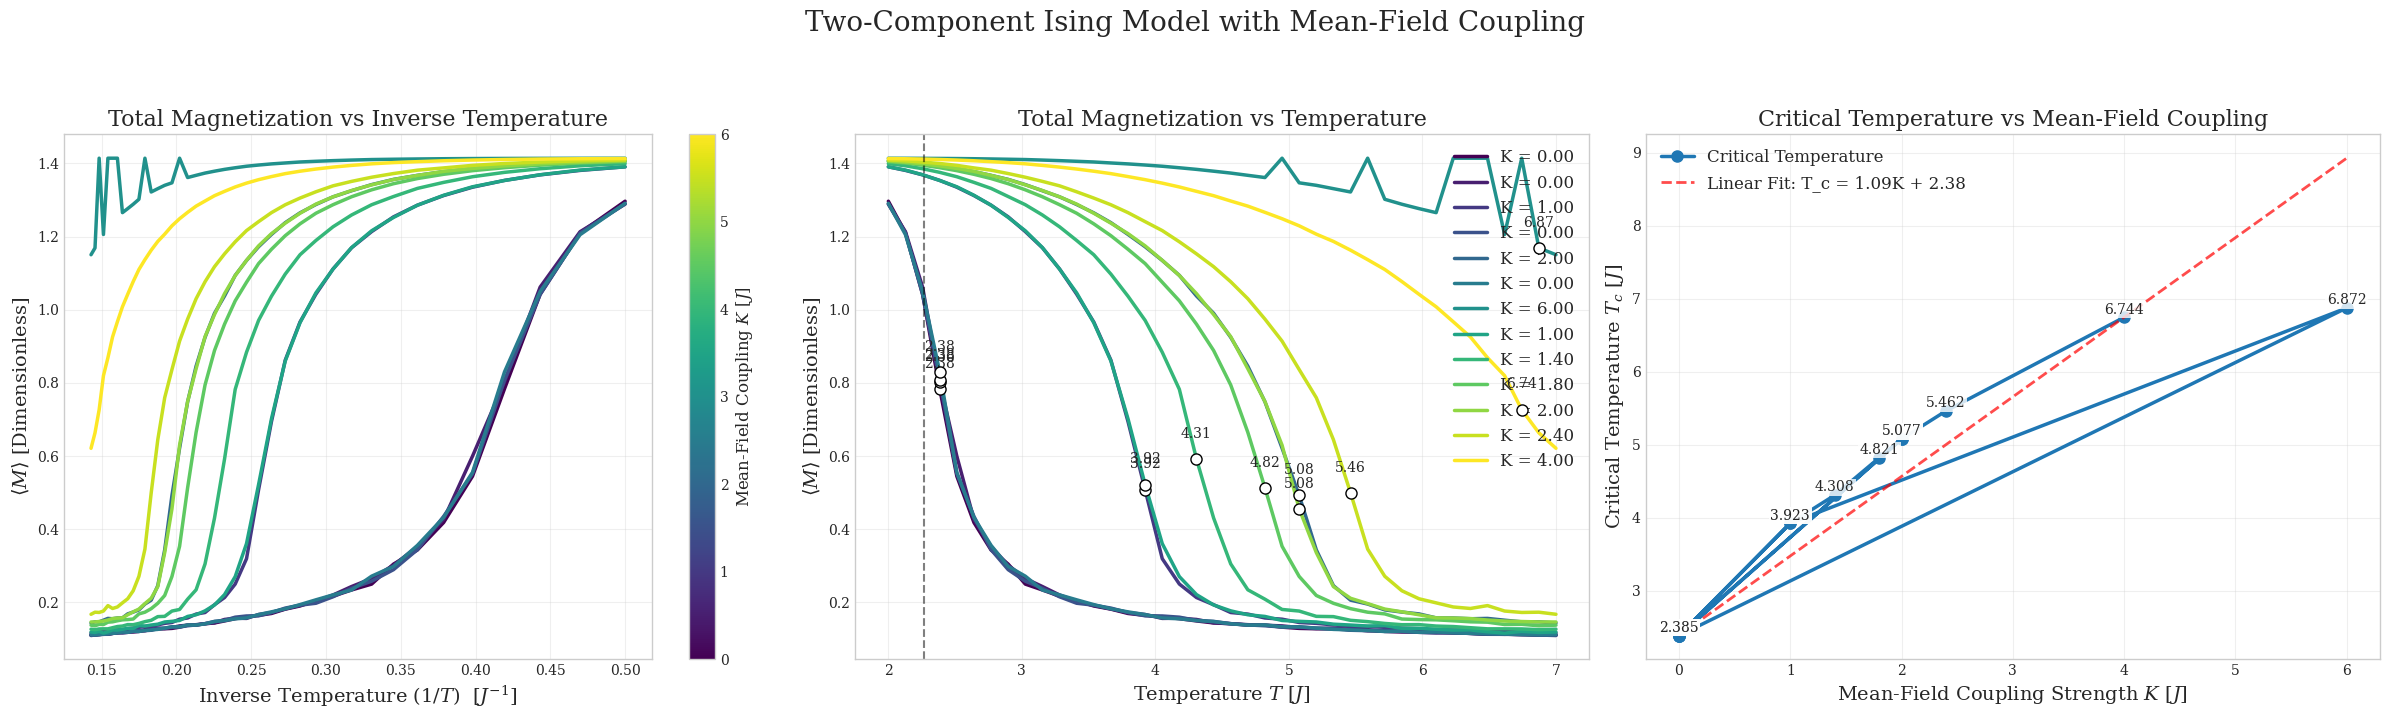


Critical Temperatures for Different Mean-Field Couplings:
K (Coupling) | T_c (Critical Temp) | ΔT_c = T_c(K) - T_c(0)
--------------------------------------------------
0.0000       | 2.3846             | 0.0000         
0.0000       | 2.3846             | 0.0000         
1.0000       | 3.9231             | 1.5385         
0.0000       | 2.3846             | 0.0000         
2.0000       | 5.0769             | 2.6923         
0.0000       | 2.3846             | 0.0000         
6.0000       | 6.8718             | 4.4872         
1.0000       | 3.9231             | 1.5385         
1.4000       | 4.3077             | 1.9231         
1.8000       | 4.8205             | 2.4359         
2.0000       | 5.0769             | 2.6923         
2.4000       | 5.4615             | 3.0769         
4.0000       | 6.7436             | 4.3590         

Summary of Mean-Field Effect:
- Without coupling (K=0): T_c = 2.3846
- With maximum coupling (K=4.0): T_c = 6.7436
- Critical temperature increase: 4.359

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# ---------------------------------------------------------------
# Configure plot aesthetics
# ---------------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['mathtext.fontset'] = 'dejavuserif'
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['axes.titlesize'] = 16
# ---------------------------------------------------------------

# Load simulation data
data = np.load('mean_field_data.npz')
K_values = data['K_values']
temperatures = data['temperatures']
all_m = data['all_m']  # Total magnetization

# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 7))

# Colormap for K values
cmap = mpl.colormaps['viridis']
colors = cmap(np.linspace(0, 1, len(K_values)))

# =================================================================
# Subplot 1: <M> vs 1/T for different K values
# =================================================================
for i, K in enumerate(K_values):
    invT = 1 / temperatures
    m_vals = all_m[i]
    ax1.plot(invT, m_vals, lw=2.5, color=colors[i], 
             label=f'K = {K:.2f}')

ax1.set_title(r'Total Magnetization vs Inverse Temperature', fontsize=16)
ax1.set_xlabel(r'Inverse Temperature $(1/T)$  [$J^{-1}$]', fontsize=14)
ax1.set_ylabel(r'$\langle M \rangle$ [Dimensionless]', fontsize=14)
ax1.grid(True, alpha=0.3)

# Add colorbar for K values
sm = plt.cm.ScalarMappable(cmap=cmap, 
                          norm=plt.Normalize(vmin=min(K_values), 
                                       vmax=max(K_values)))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax1)
cbar.set_label(r'Mean-Field Coupling $K$ [$J$]', fontsize=12)

# =================================================================
# Subplot 2: <M> vs T for different K values
# =================================================================
# Store critical temperatures for printing later
critical_temps = []

for i, K in enumerate(K_values):
    m_vals = all_m[i]
    ax2.plot(temperatures, m_vals, lw=2.5, color=colors[i], 
             label=f'K = {K:.2f}')
    
    # Compute critical temperature (inflection point)
    dM_dT = np.gradient(m_vals, temperatures)
    critical_idx = np.argmin(dM_dT)  # Steepest negative slope
    T_c = temperatures[critical_idx]
    critical_temps.append(T_c)
    
    # Mark critical point on plot
    ax2.plot(T_c, m_vals[critical_idx], 'o', markersize=8, 
             color='white', markeredgecolor='k', zorder=10)
    ax2.text(T_c, m_vals[critical_idx] + 0.05, f'{T_c:.2f}', 
             fontsize=10, ha='center', va='bottom')

ax2.set_title(r'Total Magnetization vs Temperature', fontsize=16)
ax2.set_xlabel(r'Temperature $T$ [$J$]', fontsize=14)
ax2.set_ylabel(r'$\langle M \rangle$ [Dimensionless]', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=12, loc='upper right')

# Highlight standard Ising critical temperature
ax2.axvline(2.27, color='k', linestyle='--', alpha=0.5, label='Ising T_c')

# =================================================================
# Subplot 3: Critical Temperature vs Coupling Strength (K)
# =================================================================
# Plot critical temperatures
ax3.plot(K_values, critical_temps, 'o-', lw=2.5, markersize=8, 
         color='#1f77b4', label='Critical Temperature')

# Add text annotations
for i, (k, tc) in enumerate(zip(K_values, critical_temps)):
    ax3.text(k, tc+0.05, f'{tc:.3f}', fontsize=10, ha='center', 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=1))

# Add theoretical trend line (linear approximation)
if len(K_values) > 1:
    slope = (critical_temps[-1] - critical_temps[0]) / (K_values[-1] - K_values[0])
    intercept = critical_temps[0] - slope * K_values[0]
    fit_K = np.linspace(min(K_values), max(K_values), 100)
    fit_Tc = slope * fit_K + intercept
    ax3.plot(fit_K, fit_Tc, 'r--', lw=2, alpha=0.7, 
             label=f'Linear Fit: T_c = {slope:.2f}K + {intercept:.2f}')

ax3.set_title(r'Critical Temperature vs Mean-Field Coupling', fontsize=16)
ax3.set_xlabel(r'Mean-Field Coupling Strength $K$ [$J$]', fontsize=14)
ax3.set_ylabel(r'Critical Temperature $T_c$ [$J$]', fontsize=14)
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=12)

# =================================================================
# Final formatting
# =================================================================
plt.suptitle('Two-Component Ising Model with Mean-Field Coupling', 
             fontsize=20, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('mean_field_effects.png', dpi=300, bbox_inches='tight')
plt.show()

# Print critical temperatures in a table
print("\nCritical Temperatures for Different Mean-Field Couplings:")
print("==================================================")
print(f"{'K (Coupling)':<12} | {'T_c (Critical Temp)':<18} | {'ΔT_c = T_c(K) - T_c(0)':<15}")
print("--------------------------------------------------")
for i, K in enumerate(K_values):
    delta_Tc = critical_temps[i] - critical_temps[0]
    print(f"{K:<12.4f} | {critical_temps[i]:<18.4f} | {delta_Tc:<15.4f}")
print("==================================================")

# Print summary of the effect
print("\nSummary of Mean-Field Effect:")
print(f"- Without coupling (K=0): T_c = {critical_temps[0]:.4f}")
print(f"- With maximum coupling (K={K_values[-1]}): T_c = {critical_temps[-1]:.4f}")
print(f"- Critical temperature increase: {critical_temps[-1] - critical_temps[0]:.4f} ({100*(critical_temps[-1]/critical_temps[0]-1):.1f}% increase)")
print(f"- Linear relationship: T_c ≈ {slope:.3f}K + {intercept:.3f}")

In [34]:
import numpy as np

# Load the simulation data from the .npz file
data = np.load('mean_field_data.npz')

# Store the arrays under new variable names to preserve them
K_values_prev = data['K_values']
temperatures_prev = data['temperatures']
all_m_prev = data['all_m']

print("Current simulation data has been preserved under '_prev' variable names.")

Current simulation data has been preserved under '_prev' variable names.


#### Animating an Ising Sequence

Note that this requires a live kernel, and so will not show up on the blog or other static rendering:

In [16]:
import matplotlib.pyplot as plt
from ipywidgets import interact

def random_spin_field(N, M):
    """Return an N × M array of ±1 spins as int."""
    return np.random.choice([-1, 1], size=(N, M)).astype(np.int8)

def display_spin_components(field_x, field_y):
    """Show both spin components side-by-side."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    
    # X-component (field-aligned)
    ax1.imshow(field_x, cmap='gray', vmin=-1, vmax=1)
    ax1.set_title('X-component (Field-aligned)')
    ax1.axis('off')
    
    # Y-component (perpendicular)
    ax2.imshow(field_y, cmap='gray', vmin=-1, vmax=1)
    ax2.set_title('Y-component (Perpendicular)')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

def display_two_component_sequence(frames):
    """Interactive slider through a list of (x,y) spin configurations."""
    @interact(frame=(0, len(frames) - 1))
    def _show(frame=0):
        field_x, field_y = frames[frame]
        display_spin_components(field_x, field_y)

In [18]:
# --- simulation parameters --------------------------------------
L = 100          # lattice size
T1 = 2.8         # Higher temp for x-alignment
T2 = 2.0         # Lower temp for y-alignment
h = 0.3          # Field strength in x-direction
n_frames = 100   # number of saved frames
# ---------------------------------------------------------------

# Create initial state
field_x = random_spin_field(L, L)
field_y = random_spin_field(L, L)
frames = [(field_x.copy(), field_y.copy())]

# First part: Thermalize at T1 (x-alignment)
for _ in range(n_frames//2):
    field_x, field_y = two_comp_step(field_x, field_y, beta=1/T1, J=1.0, h=h)
    frames.append((field_x.copy(), field_y.copy()))

# Second part: Cool to T2 (y-alignment)
for _ in range(n_frames//2):
    field_x, field_y = two_comp_step(field_x, field_y, beta=1/T2, J=1.0, h=h)
    frames.append((field_x.copy(), field_y.copy()))

display_two_component_sequence(frames)


TypeError: two_comp_step() got an unexpected keyword argument 'J'

# Cython - speed it up

In [21]:
pip install Cython

Note: you may need to restart the kernel to use updated packages.


In [22]:
%load_ext Cython

In [36]:
%%cython

cimport cython
import numpy as np
cimport numpy as np

from libc.math cimport exp
from libc.stdlib cimport rand
cdef extern from "limits.h":
    int RAND_MAX

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_ising_step(np.int64_t[:, :] field, float beta=0.4):
    cdef int N = field.shape[0]
    cdef int M = field.shape[1]
    cdef int n_offset, m_offset, n, m
    for n_offset in range(2):
        for m_offset in range(2):
            for n in range(n_offset, N, 2):
                for m in range(m_offset, M, 2):
                    _cy_ising_update(field, n, m, beta, N, M)
    return np.array(field)

@cython.boundscheck(False)
@cython.wraparound(False)
cdef _cy_ising_update(np.int64_t[:, :] field, int n, int m, float beta, int N, int M):
    cdef int total = 0
    # Directly compute indices for 4 orthogonal neighbors with periodic boundaries
    total += field[(n-1) % N, m]     # Up
    total += field[(n+1) % N, m]     # Down
    total += field[n, (m-1) % M]     # Left
    total += field[n, (m+1) % M]     # Right
    
    cdef float dE = 2 * field[n, m] * total
    if dE <= 0:
        field[n, m] *= -1
    elif exp(-dE * beta) * RAND_MAX > rand():
        field[n, m] *= -1

Content of stderr:
In file included from /Users/linjiancheng/.cache/ipython/cython/_cython_magic_6f1ea97a9812e21600a1121f3c80d295bf17ff3953e4f7928d618e72bf35a151.c:1147:
In file included from /opt/anaconda3/lib/python3.12/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /opt/anaconda3/lib/python3.12/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /opt/anaconda3/lib/python3.12/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929:
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
1 warning generated.

#### Timing the result

In [37]:
field = random_spin_field(200, 200)
%timeit ising_step(field)
%timeit cy_ising_step(field)

144 ms ± 3.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
864 μs ± 36.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


#### Visualizing the result

(Note that the following code requires a live kernel, and will not display within a static rendering such as the blog post):

In [45]:
images = [random_spin_field(500, 500)]
for i in range(500):
    images.append(cy_ising_step(images[-1].copy(), beta=0.7))
display_ising_sequence(images);

interactive(children=(IntSlider(value=250, description='frame', max=500), Output()), _dom_classes=('widget-int…